# Fine-Tuning Representation Models for Classification

## Supervised Classification

### Fine-Tuning a Pretrained BERT Model

In [3]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

Using the latest cached version of the dataset since rotten_tomatoes couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\IdeaPad\.cache\huggingface\datasets\rotten_tomatoes\default\0.0.0\aa13bc287fa6fcab6daf52f0dfb9994269ffea28 (last modified on Sat Mar 29 12:38:20 2025).


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Model and Tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map: 100%|██████████| 1066/1066 [00:00<00:00, 7661.35 examples/s] 


In [5]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

In [8]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [8]:
trainer.train()

 94%|█████████▎| 500/534 [02:47<00:13,  2.45it/s]

{'loss': 0.4205, 'grad_norm': 15.350017547607422, 'learning_rate': 1.2734082397003748e-06, 'epoch': 0.94}


100%|██████████| 534/534 [03:07<00:00,  2.85it/s]

{'train_runtime': 187.2086, 'train_samples_per_second': 45.564, 'train_steps_per_second': 2.852, 'train_loss': 0.41636749867642864, 'epoch': 1.0}


TrainOutput(global_step=534, training_loss=0.41636749867642864, metrics={'train_runtime': 187.2086, 'train_samples_per_second': 45.564, 'train_steps_per_second': 2.852, 'total_flos': 227605451772240.0, 'train_loss': 0.41636749867642864, 'epoch': 1.0})

In [9]:
trainer.evaluate()

100%|██████████| 67/67 [00:08<00:00,  7.73it/s]


{'eval_loss': 0.37474557757377625,
 'eval_f1': 0.8462255358807083,
 'eval_runtime': 8.9091,
 'eval_samples_per_second': 119.653,
 'eval_steps_per_second': 7.52,
 'epoch': 1.0}

### Freezing Layers

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Model and Tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Print layer names
for name, param in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [3]:
for name, param in model.named_parameters():

     # Trainable classification head
     if name.startswith("classifier"):
        param.requires_grad = True

      # Freeze everything else
     else:
        param.requires_grad = False

In [4]:
# We can check whether the model was correctly updated
for name, param in model.named_parameters():
     print(f"Parameter: {name} ----- {param.requires_grad}")

Parameter: bert.embeddings.word_embeddings.weight ----- False
Parameter: bert.embeddings.position_embeddings.weight ----- False
Parameter: bert.embeddings.token_type_embeddings.weight ----- False
Parameter: bert.embeddings.LayerNorm.weight ----- False
Parameter: bert.embeddings.LayerNorm.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: bert.encoder.layer.0.attention.output

In [9]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

 94%|█████████▍| 501/534 [01:13<00:05,  6.16it/s]

{'loss': 0.6933, 'grad_norm': 4.200374603271484, 'learning_rate': 1.2734082397003748e-06, 'epoch': 0.94}


100%|██████████| 534/534 [01:21<00:00,  6.55it/s]

{'train_runtime': 81.5224, 'train_samples_per_second': 104.634, 'train_steps_per_second': 6.55, 'train_loss': 0.693643527084522, 'epoch': 1.0}


TrainOutput(global_step=534, training_loss=0.693643527084522, metrics={'train_runtime': 81.5224, 'train_samples_per_second': 104.634, 'train_steps_per_second': 6.55, 'total_flos': 227605451772240.0, 'train_loss': 0.693643527084522, 'epoch': 1.0})

In [10]:
trainer.evaluate()

100%|██████████| 67/67 [00:12<00:00,  5.52it/s]


{'eval_loss': 0.6833594441413879,
 'eval_f1': 0.6201550387596899,
 'eval_runtime': 12.3319,
 'eval_samples_per_second': 86.442,
 'eval_steps_per_second': 5.433,
 'epoch': 1.0}

### Freeze everything up until encoder block 10

In [11]:
# Load model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Encoder block 10 starts at index 165 and
# we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 94%|█████████▎| 500/534 [01:38<00:07,  4.38it/s]

{'loss': 0.4744, 'grad_norm': 4.441214084625244, 'learning_rate': 1.2734082397003748e-06, 'epoch': 0.94}


100%|██████████| 534/534 [01:49<00:00,  4.90it/s]


{'train_runtime': 109.09, 'train_samples_per_second': 78.192, 'train_steps_per_second': 4.895, 'train_loss': 0.46974131587739293, 'epoch': 1.0}


100%|██████████| 67/67 [00:12<00:00,  5.46it/s]


{'eval_loss': 0.4083769917488098,
 'eval_f1': 0.8128031037827352,
 'eval_runtime': 12.3918,
 'eval_samples_per_second': 86.025,
 'eval_steps_per_second': 5.407,
 'epoch': 1.0}

In [ ]:
# scores = []
# for index in range(12):
#     # Re-load model
#     model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
#     tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

#     # Freeze encoder blocks 0-index
#     for name, param in model.named_parameters():
#         if "layer" in name:
#             layer_nr = int(name.split("layer")[1].split(".")[1])
#             if layer_nr <= index:
#                 param.requires_grad = False
#         else:
#             param.requires_grad = True

#     # Train
#     trainer = Trainer(
#       model=model,
#       args=training_args,
#       train_dataset=tokenized_train,
#       eval_dataset=tokenized_test,
#       tokenizer=tokenizer,
#       data_collator=data_collator,
#       compute_metrics=compute_metrics,
#     )
#     trainer.train()

#     # Evaluate
#     score = trainer.evaluate()["eval_f1"]
#     scores.append(score)

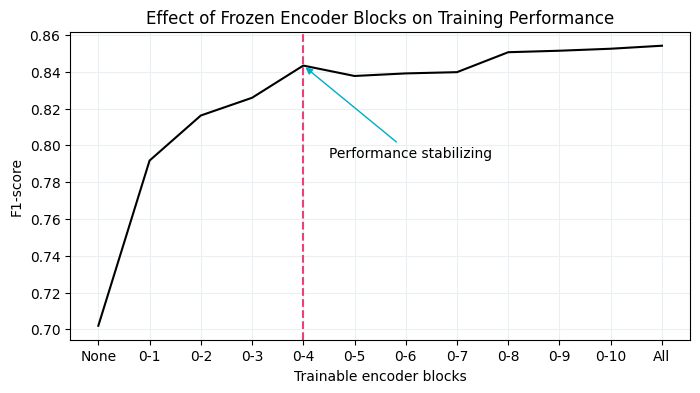

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create Figure
plt.figure(figsize=(8,4))

# Prepare Data
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = [
    0.8541862652869239,
    0.8525519848771267,
    0.8514664143803217,
    0.8506616257088847,
    0.8398104265402844,
    0.8391345249294448,
    0.8377358490566037,
    0.8433962264150944,
    0.8258801141769743,
    0.816247582205029,
    0.7917485265225934,
    0.7019400352733686
][::-1]

# Stylize Figure
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# Plot Data
plt.plot(x, y, color="black")

# Additional Annotation
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4]-.05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

## Few-Shot Classification

In [35]:
from setfit import sample_dataset

# We simulate a few-shot setting by sampling 16 examples per class
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [36]:
from setfit import SetFitModel

# Load a pre-trained SentenceTransformer model
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [37]:
from setfit import TrainingArguments as SetFitTrainingArguments
from setfit import Trainer as SetFitTrainer

# Define training arguments
args = SetFitTrainingArguments(
    num_epochs=3, # The number of epochs to use for contrastive learning
    num_iterations=20  # The number of text pairs to generate
)
args.eval_strategy = args.evaluation_strategy

# Create trainer
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 32/32 [00:00<00:00, 4225.20 examples/s]


In [7]:
# Training loop
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3
  0%|          | 1/240 [00:04<18:26,  4.63s/it]

{'embedding_loss': 0.3085, 'grad_norm': 2.036525011062622, 'learning_rate': 8.333333333333333e-07, 'epoch': 0.01}


 21%|██        | 50/240 [00:41<02:19,  1.36it/s]

{'embedding_loss': 0.1157, 'grad_norm': 0.15513768792152405, 'learning_rate': 1.7592592592592595e-05, 'epoch': 0.62}


 42%|████▏     | 100/240 [01:25<02:27,  1.05s/it]

{'embedding_loss': 0.001, 'grad_norm': 0.05414820834994316, 'learning_rate': 1.2962962962962964e-05, 'epoch': 1.25}


 62%|██████▎   | 150/240 [02:12<01:23,  1.08it/s]

{'embedding_loss': 0.0005, 'grad_norm': 0.01988757960498333, 'learning_rate': 8.333333333333334e-06, 'epoch': 1.88}


 83%|████████▎ | 200/240 [02:49<00:27,  1.45it/s]

{'embedding_loss': 0.0003, 'grad_norm': 0.012995349243283272, 'learning_rate': 3.7037037037037037e-06, 'epoch': 2.5}


100%|██████████| 240/240 [03:25<00:00,  1.17it/s]


{'train_runtime': 205.4188, 'train_samples_per_second': 18.694, 'train_steps_per_second': 1.168, 'train_loss': 0.02534471363760531, 'epoch': 3.0}


In [8]:
# Evaluate the model on our test data
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.8464491362763915}

In [9]:
model.model_head

LogisticRegression()

## Continue Pretraining with Masked Language Modeling

!["1115"](img/11.15.png)

In [17]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load model for Masked Language Modeling (MLM)
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

In [18]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

# Tokenize data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Map: 100%|██████████| 1066/1066 [00:00<00:00, 13920.42 examples/s]


In [19]:
from transformers import DataCollatorForLanguageModeling

# Masking Tokens
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

In [30]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)


# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [31]:
# Save pre-trained tokenizer
tokenizer.save_pretrained("mlm")

# Train model
trainer.train()

# Save updated model
model.save_pretrained("mlm")

                                                 
  1%|          | 31/5340 [05:26<46:13,  1.91it/s]

{'loss': 2.5431, 'grad_norm': 13.505681037902832, 'learning_rate': 1.2734082397003748e-06, 'epoch': 0.94}


                                                 
100%|██████████| 534/534 [05:11<00:00,  1.71it/s]


{'train_runtime': 311.5539, 'train_samples_per_second': 27.379, 'train_steps_per_second': 1.714, 'train_loss': 2.5445126594229137, 'epoch': 1.0}


In [1]:
from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [2]:
# Load and create predictions
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


>>> What a horrible movie!
>>> What a horrible story!
>>> What a horrible mess!
>>> What a horrible thing!
>>> What a horrible joke!


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load Model and Tokenizer
model_id = "mlm"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

from transformers import DataCollatorWithPadding

# Pad to the longest sequence in the batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
   """Tokenize input data"""
   return tokenizer(examples["text"], truncation=True)

# Tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 94%|█████████▎| 500/534 [02:56<00:10,  3.12it/s]

{'loss': 0.4144, 'grad_norm': 13.293235778808594, 'learning_rate': 1.2734082397003748e-06, 'epoch': 0.94}


100%|██████████| 534/534 [03:15<00:00,  2.74it/s]

{'train_runtime': 195.2002, 'train_samples_per_second': 43.699, 'train_steps_per_second': 2.736, 'train_loss': 0.4097407212418117, 'epoch': 1.0}


TrainOutput(global_step=534, training_loss=0.4097407212418117, metrics={'train_runtime': 195.2002, 'train_samples_per_second': 43.699, 'train_steps_per_second': 2.736, 'total_flos': 227605451772240.0, 'train_loss': 0.4097407212418117, 'epoch': 1.0})

In [7]:
trainer.evaluate()

100%|██████████| 67/67 [00:09<00:00,  6.76it/s]


{'eval_loss': 0.3713599145412445,
 'eval_f1': 0.8563327032136105,
 'eval_runtime': 10.2177,
 'eval_samples_per_second': 104.328,
 'eval_steps_per_second': 6.557,
 'epoch': 1.0}

## Named-entity Recognition

!["1119"](img/11.19.png)

In [8]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import numpy as np

In [9]:
# The CoNLL-2003 dataset for NER
dataset = load_dataset("conll2003", trust_remote_code=True)

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\IdeaPad\.cache\huggingface\hub\datasets--conll2003. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 3453/3453 [00:00<00:00, 6189.67 examples/s]


In [10]:
example = dataset["train"][848]
example

{'id': '848',
 'tokens': ['Dean',
  'Palmer',
  'hit',
  'his',
  '30th',
  'homer',
  'for',
  'the',
  'Rangers',
  '.'],
 'pos_tags': [22, 22, 38, 29, 16, 21, 15, 12, 23, 7],
 'chunk_tags': [11, 12, 21, 11, 12, 12, 13, 11, 12, 0],
 'ner_tags': [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]}

In [11]:
label2id = {
    'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4,
    'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8
}
id2label = {index: label for label, index in label2id.items()}
label2id

{'O': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-ORG': 3,
 'I-ORG': 4,
 'B-LOC': 5,
 'I-LOC': 6,
 'B-MISC': 7,
 'I-MISC': 8}

In [12]:
from transformers import AutoModelForTokenClassification

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Load model
model = AutoModelForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Split individual tokens into sub-tokens
token_ids = tokenizer(example["tokens"], is_split_into_words=True)["input_ids"]
sub_tokens = tokenizer.convert_ids_to_tokens(token_ids)
sub_tokens

['[CLS]',
 'Dean',
 'Palmer',
 'hit',
 'his',
 '30th',
 'home',
 '##r',
 'for',
 'the',
 'Rangers',
 '.',
 '[SEP]']

In [26]:
def align_labels(examples):
    token_ids = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = examples["ner_tags"]

    updated_labels = []
    for index, label in enumerate(labels):

        # Map tokens to their respective word
        word_ids = token_ids.word_ids(batch_index=index)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:

            # The start of a new word
            if word_idx != previous_word_idx:

                previous_word_idx = word_idx
                updated_label = -100 if word_idx is None else label[word_idx]
                label_ids.append(updated_label)

            # Special token is -100
            elif word_idx is None:
                label_ids.append(-100)

            # If the label is B-XXX we change it to I-XXX
            else:
                updated_label = label[word_idx]
                if updated_label % 2 == 1:
                    updated_label += 1
                label_ids.append(updated_label)

        updated_labels.append(label_ids)

    token_ids["labels"] = updated_labels
    return token_ids

tokenized = dataset.map(align_labels, batched=True)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map: 100%|██████████| 3453/3453 [00:00<00:00, 12756.55 examples/s]


In [27]:
# Difference between original and updated labels
print(f"Original: {example['ner_tags']}")
print(f"Updated: {tokenized['train'][848]['labels']}")

Original: [1, 2, 0, 0, 0, 0, 0, 0, 3, 0]
Updated: [-100, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, -100]


In [29]:
import evaluate

# Load sequential evaluation
seqeval = evaluate.load("seqeval")

def compute_metrics(eval_pred):
    # Create predictions
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2)

    true_predictions = []
    true_labels = []

    # Document-level iteration
    for prediction, label in zip(predictions, labels):

      # token-level iteration
      for token_prediction, token_label in zip(prediction, label):

        # We ignore special tokens
        if token_label != -100:
          true_predictions.append([id2label[token_prediction]])
          true_labels.append([id2label[token_label]])

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {"f1": results["overall_f1"]}

In [30]:
from transformers import DataCollatorForTokenClassification

# Token-classification Data Collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [31]:
# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()

 57%|█████▋    | 500/878 [03:30<03:25,  1.84it/s]

{'loss': 0.2276, 'grad_norm': 1.3758715391159058, 'learning_rate': 8.610478359908885e-06, 'epoch': 0.57}


100%|██████████| 878/878 [06:36<00:00,  2.22it/s]

{'train_runtime': 396.0803, 'train_samples_per_second': 35.45, 'train_steps_per_second': 2.217, 'train_loss': 0.16488116966021632, 'epoch': 1.0}


TrainOutput(global_step=878, training_loss=0.16488116966021632, metrics={'train_runtime': 396.0803, 'train_samples_per_second': 35.45, 'train_steps_per_second': 2.217, 'total_flos': 351240792638148.0, 'train_loss': 0.16488116966021632, 'epoch': 1.0})

In [32]:
# Evaluate the model on our test data
trainer.evaluate()

100%|██████████| 216/216 [00:32<00:00,  6.59it/s]


{'eval_loss': 0.14390742778778076,
 'eval_f1': 0.902149033570702,
 'eval_runtime': 32.929,
 'eval_samples_per_second': 104.862,
 'eval_steps_per_second': 6.56,
 'epoch': 1.0}

In [33]:
from transformers import pipeline

# Save our fine-tuned model
trainer.save_model("ner_model")

# Run inference on the fine-tuned model
token_classifier = pipeline(
    "token-classification",
    model="ner_model",
)
token_classifier("My name is Maarten.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity': 'B-PER',
  'score': 0.9917218,
  'index': 4,
  'word': 'Ma',
  'start': 11,
  'end': 13},
 {'entity': 'I-PER',
  'score': 0.97077405,
  'index': 5,
  'word': '##arte',
  'start': 13,
  'end': 17},
 {'entity': 'I-PER',
  'score': 0.984021,
  'index': 6,
  'word': '##n',
  'start': 17,
  'end': 18}]